<a href="https://colab.research.google.com/github/olegoid/MLDS_ML_2022/blob/main/baseline_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from workers import clean_text
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
import kaggle

In [173]:
!kaggle competitions download -c hse-nlp-bootcamp

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [174]:
df = pd.read_csv('train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


# Some EDA

Сразу видим, что в столбце с целевой переменной (`grades`) есть пропуски. В этом ноутбуке будем обучаться на отзывах, для которых есть информация о значении таргета. **Но это не единственный подход. Подумайте, что ещё можно сделать**

Посмотрим, есть ли пропуски в признаках

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bank    75000 non-null  object 
 1   feeds   75000 non-null  object 
 2   grades  51476 non-null  float64
 3   date    75000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


Сразу видим, что пропущенных значений в таргете довольно много. Что можно сделать?

- Заменить пропуски на median, mean, mode, etc.
- Убрать пропуски
- Попробовать [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html). Думаю, что это разумно так как в остальных фичах пропусков нет совсем.

In [176]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import KNNImputer

# imp = KNNImputer(n_neighbors=3, weights="uniform")
# imputed = imp.fit_transform(df)
# df_imputed = pd.DataFrame(imputed, columns=df.columns)
# df

Сразу преобразуем столбец с меткой времени к соответствующему формату (timestamp)

In [177]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df['ts'] = df['date'].values.astype(np.int64) // 10 ** 9
df = df.drop('date', axis=1)
df = df.dropna()
df = df.astype({'grades': 'int32'})
df = df.reset_index(drop=True)
df

,bank,feeds,grades,ts
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,1487261400
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,1481591100
2,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,1596523080
3,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,1429474260
4,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,1553798160
...,...,...,...,...
51471,trust,Три года длится эпопея с закрытием кредитной к...,1,1477479780
51472,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,1580591220
51473,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,1465920180
51474,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,1587457440


Посмотрим на распределение числа отзывов по банкам

In [178]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
intesa            31
primsotsbank      31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

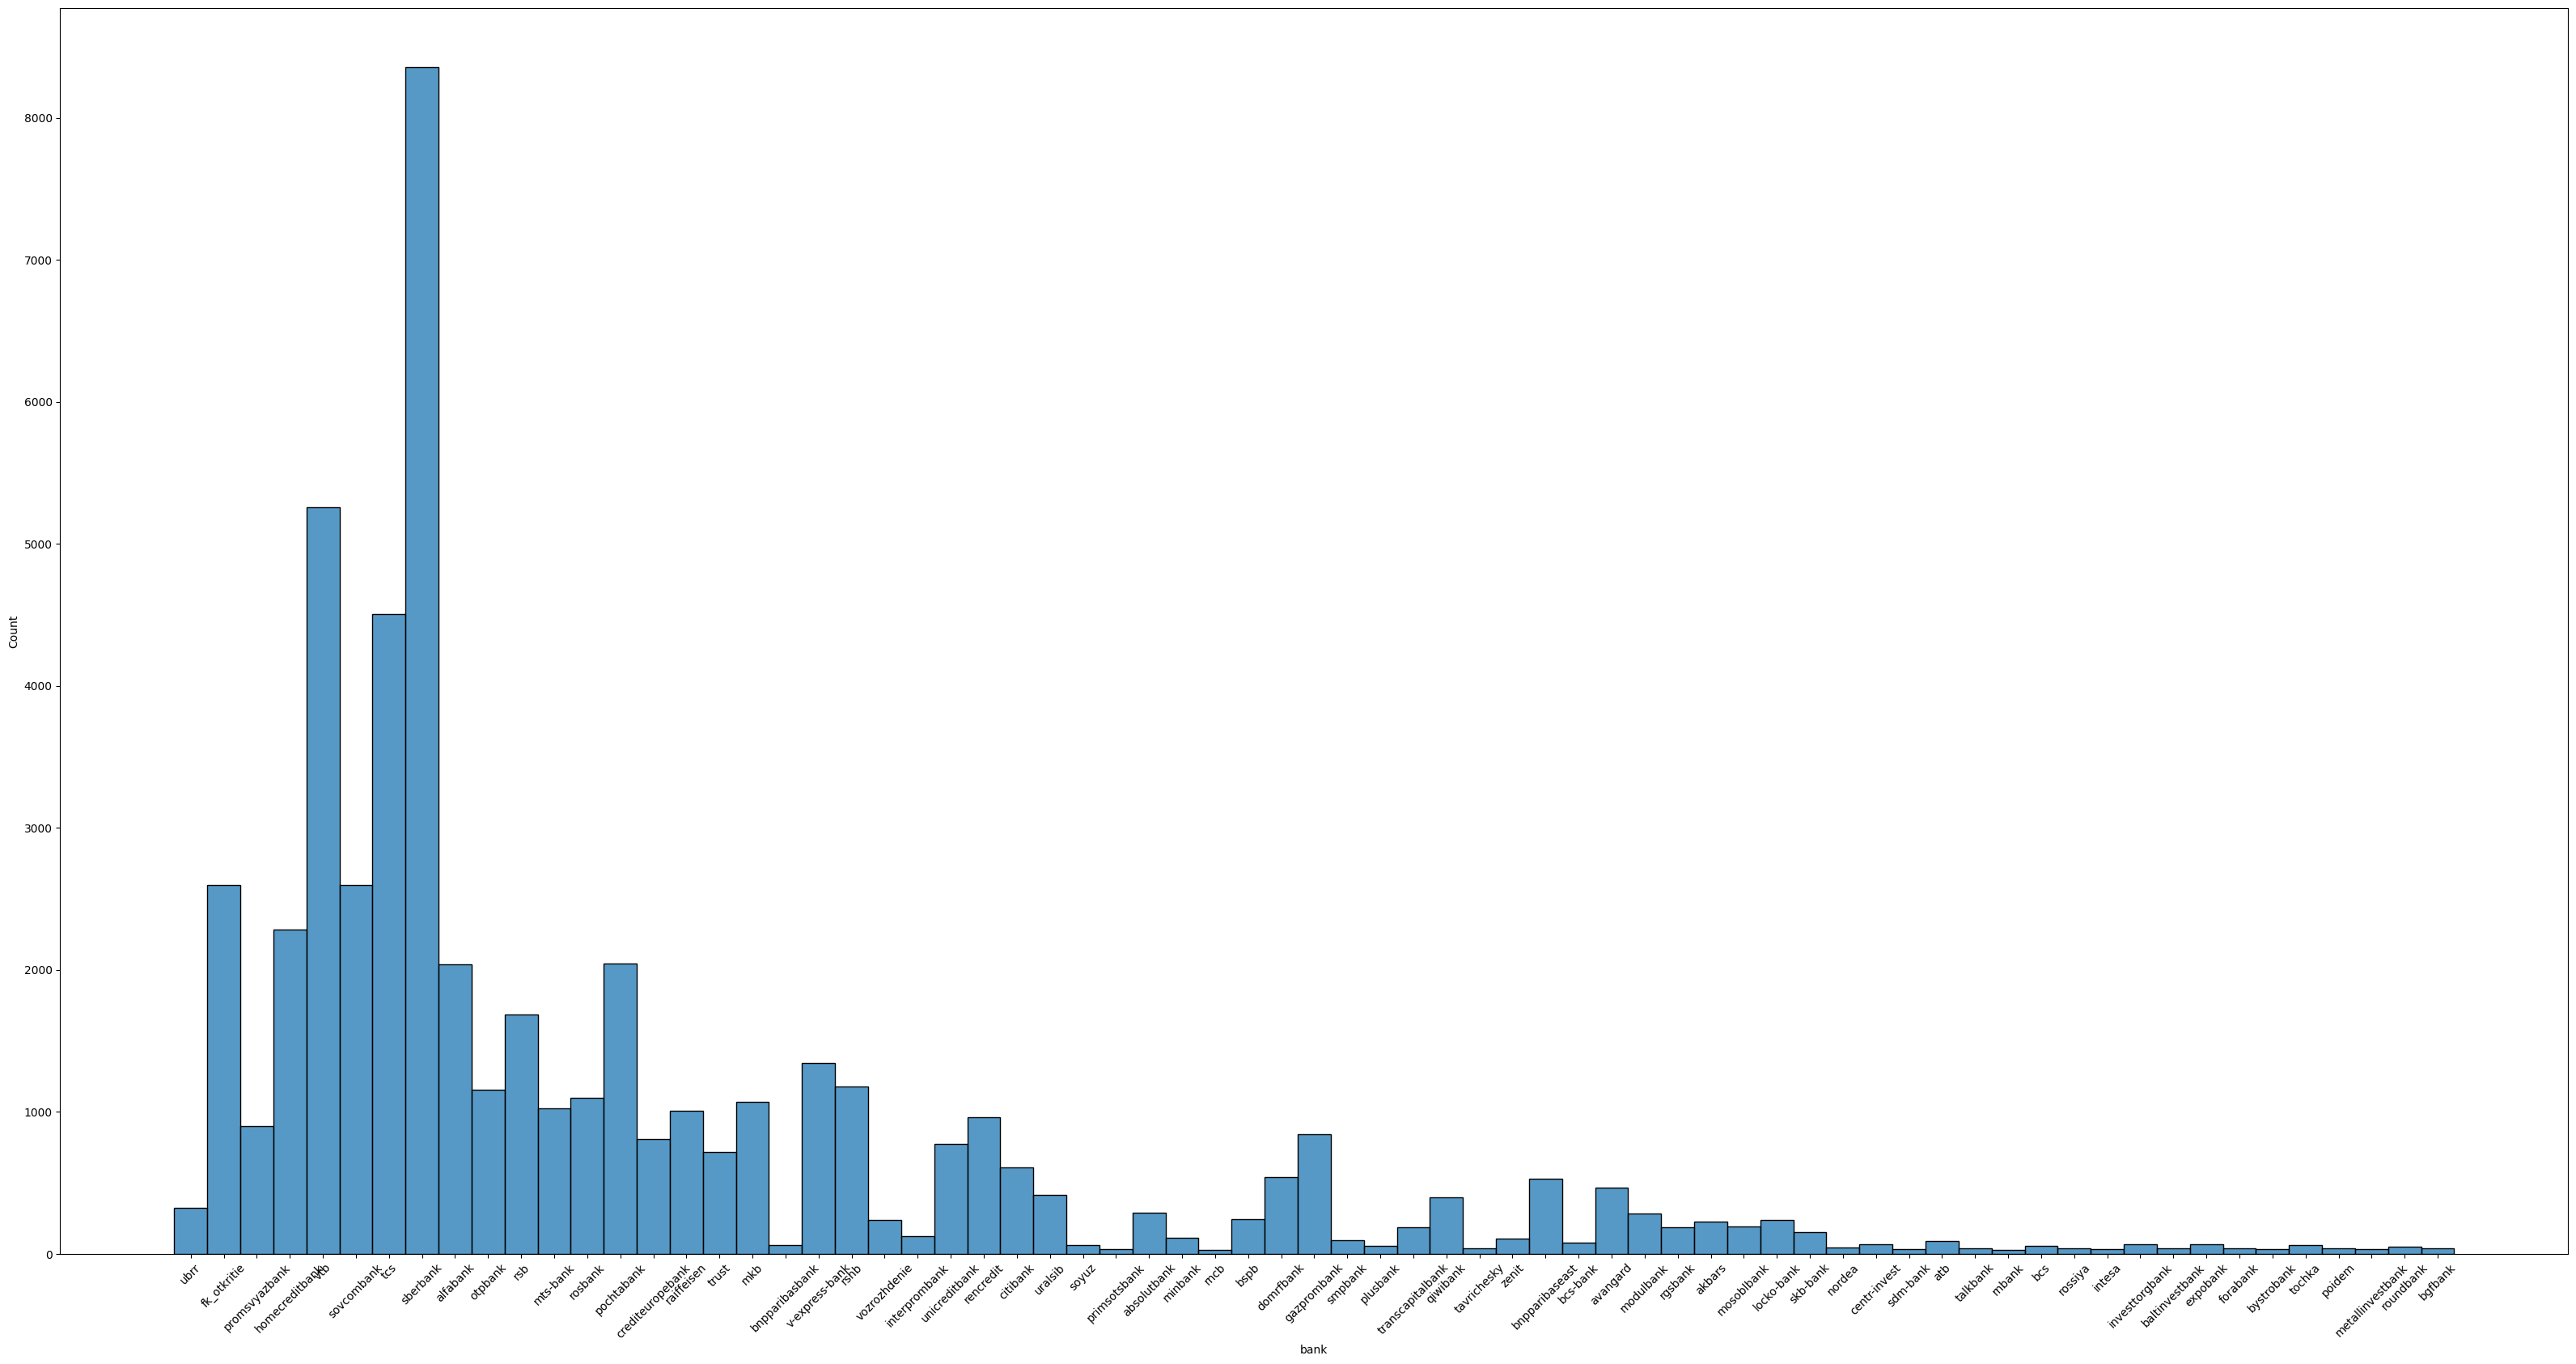

In [179]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), 
             x=df.bank, )
plt.xticks(rotation=45)
plt.show()

Глянем на распределение клиентских оценок

In [180]:
df.grades.value_counts().sort_index()

1    27739
2     5634
3     2356
4     1520
5    14227
Name: grades, dtype: int64

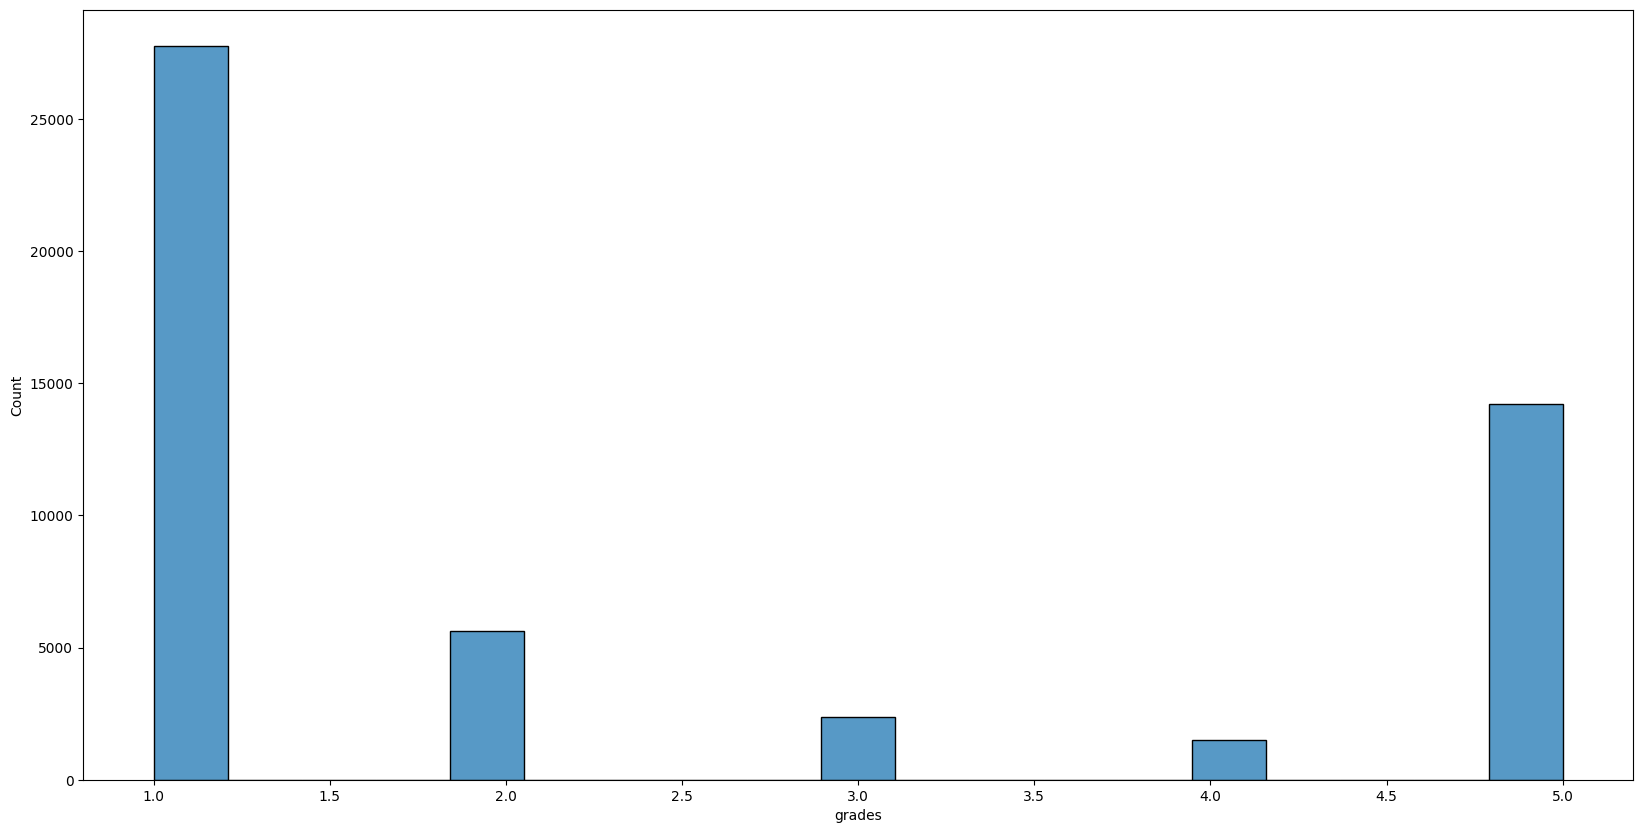

In [181]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, 
             x=df.grades, )
plt.show()

In [182]:
# check the distribution
df['grades'].value_counts()/df.shape[0]

1    0.538872
5    0.276381
2    0.109449
3    0.045769
4    0.029528
Name: grades, dtype: float64

Также нас интересуют длины отзывов

In [183]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

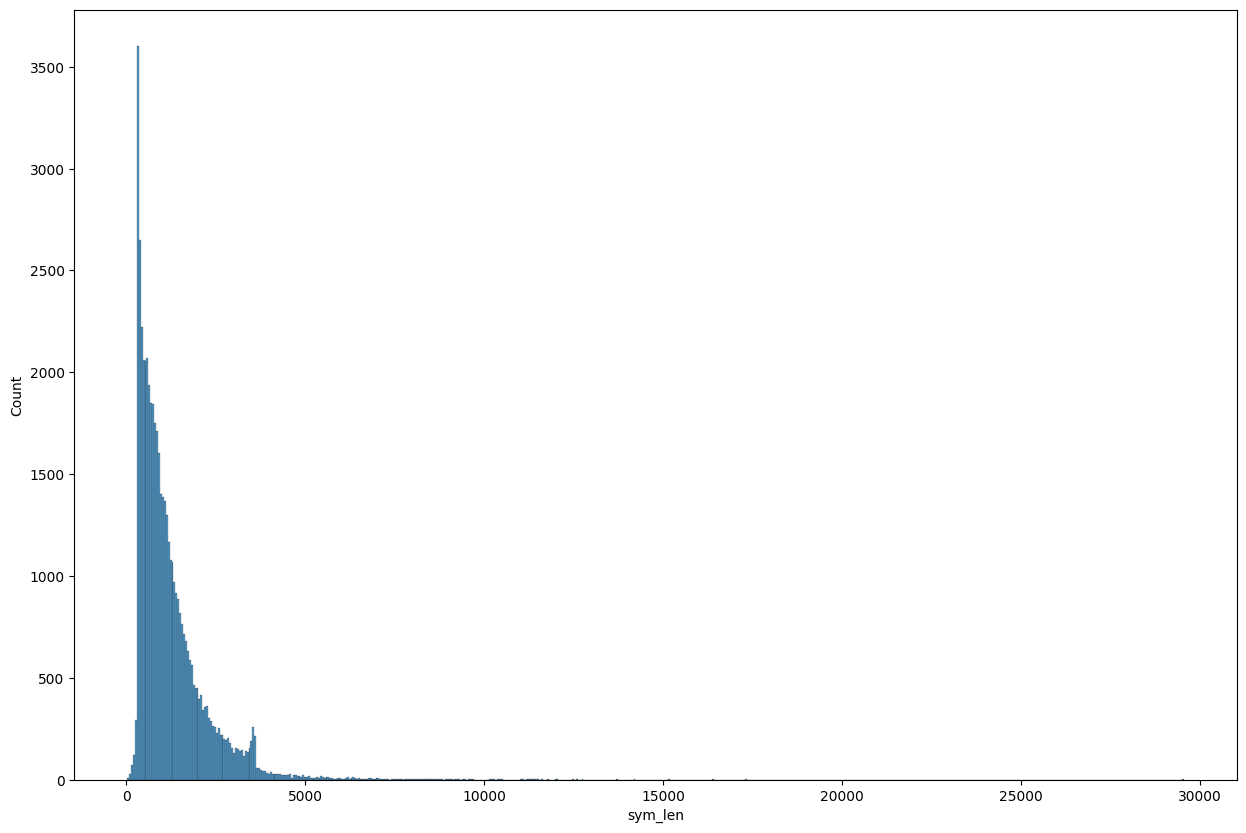

In [184]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

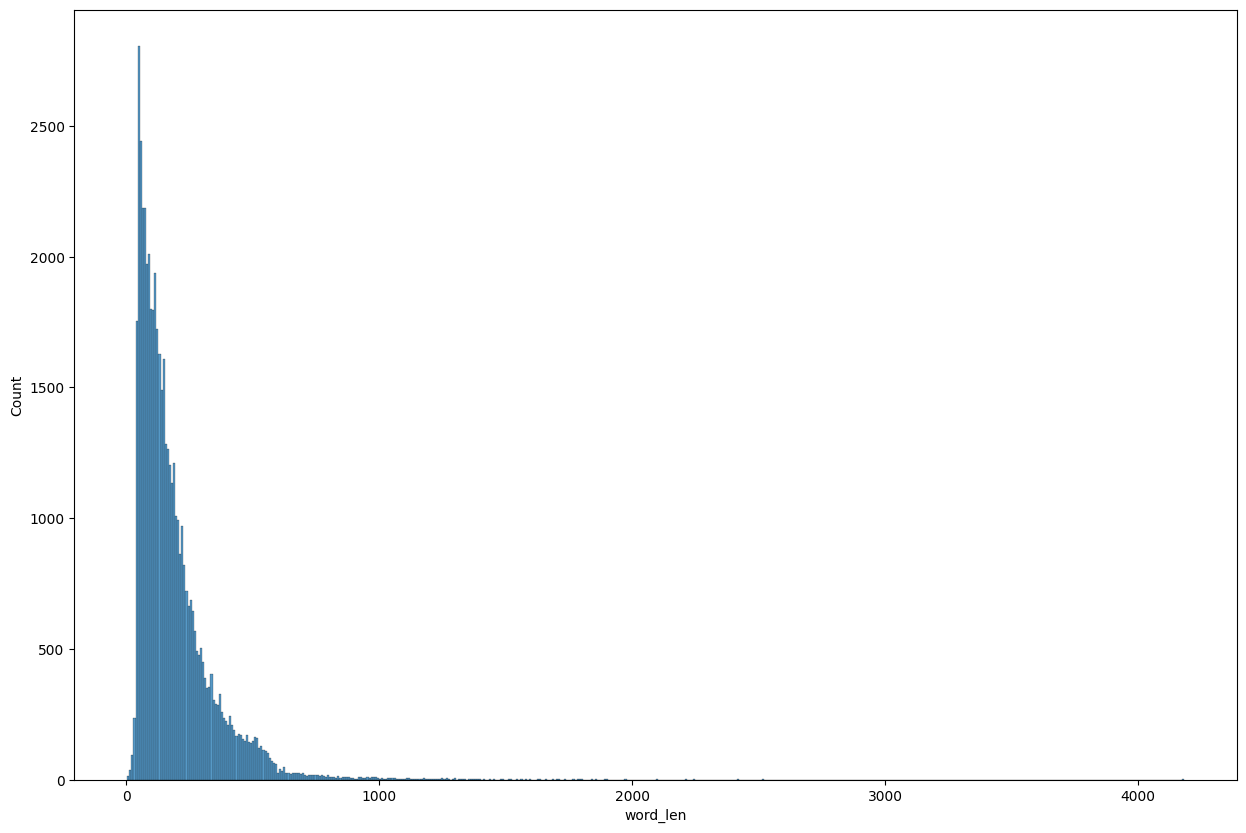

In [185]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

Обратите внимание, у распределений очень длинные хвосты

# Baseline (tf-idf + logreg)

Подготавливаем тексты отзывов (взято из ноутбука второго занятия 😃)

In [186]:
df1 = df #.head(10)

if __name__ ==  '__main__': 
    with Pool(4) as p:
        lemmas = list(tqdm(p.imap(clean_text, df1['feeds']), total=len(df1)))
    
df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 51476/51476 [04:41<00:00, 183.09it/s]


,bank,feeds,grades,ts,sym_len,word_len,lemmas
8893,crediteuropebank,Доброго времени суток. Хотелось бы понять один...,2,1402953420,831,123,добрый время сутки хотеться понять момент имен...
35762,pochtabank,"Самый худший банк, в котом когда-либо обслужив...",1,1594486200,1153,172,самый плохой банк либо обслуживаться подать за...
31474,vozrozhdenie,"Речь пойдёт о Волжском филиале Банка ""Возрожде...",5,1161681900,1415,205,речь пойда волжский филиал банк возрождение во...
44851,vtb,Я с мужем получаем зарплату на карту ВТБ с мая...,1,1522143420,483,73,получать зарплата карта недавно хотеть взять п...
47866,pochtabank,Получила предложение оформить кредитную карту ...,5,1470407160,578,80,получить предложение оформить кредитный карта ...


Будем обучаться исключительно на текстах отзывов (признаки `bank` и `date` не используем от слова совсем -- **мы не используем, а вы в своих решениях попробуйте**)

Обучимся на всех объектах, а потом сделаем предсказание на тесте из соревнования. Ни больше, ни меньше

In [187]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2)) # используем уни-, биграммы
tf_idf_matrix = vec.fit_transform(lemmas)
tf_idf_matrix = pd.DataFrame.sparse.from_spmatrix(tf_idf_matrix, columns=vec.get_feature_names_out())
tf_idf_matrix


CPU times: total: 25.5 s
Wall time: 28.7 s


,aamerican,aamerican express,aapl,aapl apple,abcd,abcd калужскаяимя,abelt,abelt думать,about,about news,...,ёмкий хотя,ёмко,ёмко давать,ёмко очень,ёмкость,ёмкость банк,ёмкость оригинально,ёмкость отделение,ёрзать,ёрзать место
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
tf_idf_matrix['bank'] = df['bank']

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# bank
transformed = ohe.fit_transform(tf_idf_matrix[['bank']])
tf_idf_matrix[ohe.categories_[0]] = transformed.toarray()
tf_idf_matrix = tf_idf_matrix.drop('bank', axis=1)
tf_idf_matrix

tf_idf_matrix['ts'] = df['ts']
tf_idf_matrix['sym_len'] = df['sym_len']
tf_idf_matrix['word_len'] = df['word_len']
tf_idf_matrix['grades'] = df['grades']

# del df

In [189]:
tf_idf_matrix

,aamerican,aamerican express,aapl,aapl apple,abcd,abcd калужскаяимя,abelt,abelt думать,about,about news,...,tcs,tochka,transcapitalbank,v-express-bank,vozrozhdenie,vtb,ts,sym_len,word_len,grades
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1487261400,1286,197,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1481591100,1000,158,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1596523080,1614,230,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1429474260,438,53,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1553798160,1175,186,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1477479780,563,90,1
51472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1580591220,1007,150,2
51473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1465920180,1223,190,1
51474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1587457440,400,57,3


In [190]:
y_train = tf_idf_matrix.grades
y_train = y_train.reset_index().drop(columns='index')

tf_idf_matrix = tf_idf_matrix.drop(columns='grades')
X_train = tf_idf_matrix

In [199]:
w = {1:0.538872, 5:0.276381, 2:0.109449, 3:0.045769, 4:0.029528}

clf = LogisticRegression(random_state=42, class_weight=w)
# небольшой трюк: будем обучаться частями
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 1000) # разобъем на 10 частей
# и подмешаем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(X_train.iloc[chunk], y_train.iloc[chunk])


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  0%|          | 1/1000 [07:33<125:49:49, 453.44s/it]


KeyboardInterrupt: 

Загрузим тест. Предобработаем отзывы в нем и сделаем предсказания

In [ ]:
test = pd.read_csv('new_test_ml.csv', index_col=0)
test

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41
...,...,...,...
17215,sberbank,"21.09.2018 в 15:26:56, я, О-ва К. К., снимала ...",22.09.2018 16:08
17216,homecreditbank,"Наверняка не засчитают, но тем не менее. Нужна...",06.10.2011 9:35
17217,interprombank,"15.08.2019 я, как физ.лицо обратилась в офис н...",21.08.2019 14:13
17218,otpbank,"У банка есть рекламный продукт-игра ""Мои рыбки...",29.05.2020 16:12


In [ ]:
with Pool(4) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
    

100%|██████████| 17220/17220 [07:24<00:00, 38.75it/s]


In [ ]:
pred = clf.predict(vec.transform(lemmas_test))
pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred})
sol

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
17215,17215,1
17216,17216,1
17217,17217,1
17218,17218,1


In [ ]:
sol.to_csv('new_baseline.csv', index=False)

Кстати, если обратите внимание на содержимое вектора предсказанных классов, то наверняка заметите, что модель предсказывает только 1 и 5, редко 2 и 3 и вообще никогда класс 4. Отчасти это логично -- наблюдается сильный дисбаланс классов. Но этот недочет неплохо бы исправить в ваших решениях

In [ ]:
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T

array([[    1, 12381],
       [    2,    48],
       [    3,     1],
       [    5,  4790]])